In [22]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

## load the dataset

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
x_train_normalized = x_train.astype(np.float32) / 255.0
x_train_normalized = x_train_normalized.reshape(-1, 28 * 28)

In [4]:
x_train_normalized.shape

(60000, 784)

## build the generator

In [16]:
hidden_dim = 100
lr = 0.001
batch_size = 64
num_epochs = 5

In [6]:
gen = keras.models.Sequential([
    keras.layers.Input(shape=(hidden_dim,)),
    keras.layers.Dense(units=128, activation="relu"),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dense(units=512, activation="relu"),
    keras.layers.Dense(units=28*28, activation="tanh")
])

In [7]:
gen.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          12,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 784)                 │         402,192 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 579,728 (2.21 MB)

 Trainable params: 579,728 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

## how to compute the parameters:
### for dense_4: (100 * 128) + 128 = 12,928
### dense_5: (128 * 256) + 256 = 33,024
### dense_6: (256 * 512) + 512 = 131,584
### dense_7: (512 * 784) + 784 = 402,192

## build the critic

In [8]:
critic = keras.models.Sequential([
    keras.layers.Input(shape=(28*28, )),
    keras.layers.Dense(units=512, activation="leaky_relu"),
    keras.layers.Dense(units=256, activation="leaky_relu"),
    keras.layers.Dense(units=1, activation="sigmoid")
])

In [9]:
critic.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

## how to compute the parameters:
### for dense_8: (784 * 512) + 512 = 401,920
### dense_9: (512 * 256) + 256 = 131,328
### dense_10: (256 * 1) + 1 = 257

In [10]:
critic.compile(optimizer=keras.optimizers.Adam(lr), loss="binary_crossentropy", metrics=["accuracy"])

In [11]:
critic.trainable = False   # freezing the critic while training the generator

In [12]:
gan_input = keras.layers.Input(shape=(hidden_dim,))
fake_image = gen(gan_input)
gan_output = critic(fake_image)

In [13]:
gan = keras.models.Model(inputs=gan_input, outputs=gan_output)

In [14]:
gan.compile(optimizer=keras.optimizers.Adam(lr), loss="binary_crossentropy", metrics=["accuracy"])

### training part

In [ ]:
for epoch in range(num_epochs):
  for _ in range(x_train_normalized.shape[0] // batch_size):
    # generate random noise
    noise = np.random.normal(0, 1, size=[batch_size, hidden_dim])

    # generate fake images
    generated_images = gen.predict(noise)

    # get a random set of real images
    image_batch = x_train_normalized[np.random.choice(x_train_normalized.shape[0],
                                                      size=batch_size, replace=False)]

    # create labels for real and fake images
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    # train the critic
    d_loss_real = critic.train_on_batch(image_batch, real_labels)
    d_loss_fake = critic.train_on_batch(generated_images, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # train the generator
    noise = np.random.normal(0, 1, size=[batch_size, hidden_dim])
    g_loss = gan.train_on_batch(noise, real_labels)

  print(f"epoch: {epoch+1}/{num_epochs}, critic loss: {d_loss[0]:.4f}, generator loss: {g_loss:.4f}")

  if (epoch + 1) % 10 == 0:
    noise = np.random.normal(0, 1, size=[16, hidden_dim])
    generated_images = generator.predict(noise)
    generated_images = np.reshape(generated_images, (-1, 28, 28))

    plt.figure(figsize=(10, 10))
    for i in range(generated_images.shape[0]):
      plt.subplot(4, 4, i + 1)

      plt.imshow(generated_images[i], interpolation="nearest", cmap="gray")
      plt.axis("off")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


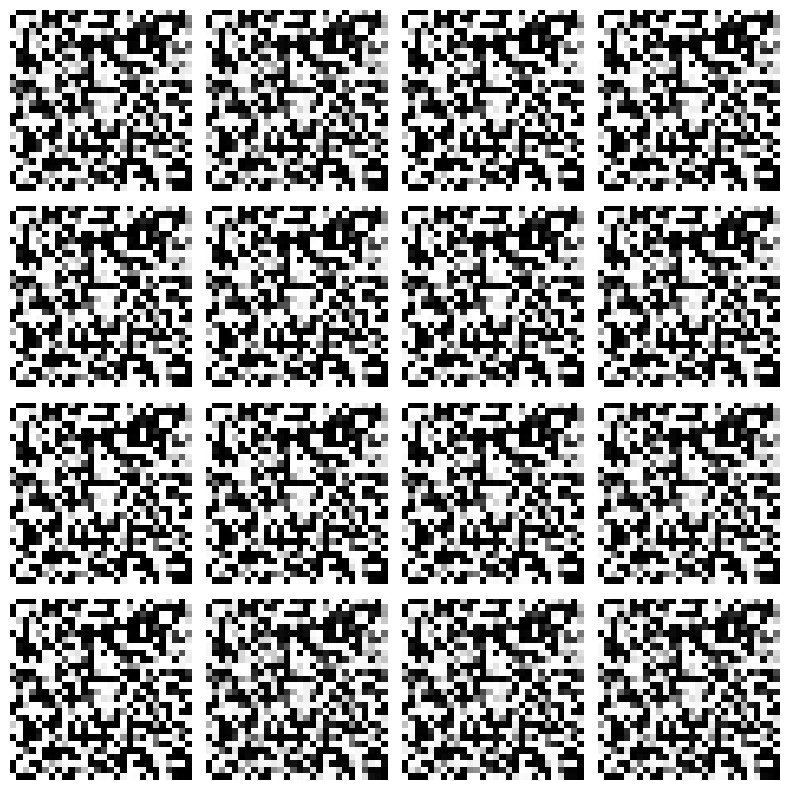

In [26]:
noise = np.random.normal(0, 1, size=[16, hidden_dim])
generated_images = gen.predict(noise)
generated_images = np.reshape(generated_images, (-1, 28, 28))


plt.figure(figsize=(8, 8))
for i in range(generated_images.shape[0]):
  plt.subplot(4, 4, i + 1)

  plt.imshow(generated_images[i], interpolation="nearest", cmap="gray")
  plt.axis("off")

plt.tight_layout()
plt.show()